In [1]:
%load_ext autoreload
%autoreload 2



%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

# Comparie pis

In [22]:
pi_batch = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_age/pi_enroll_age_offset_0_sex_0_10000_try2.pt")

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/785634992.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_batch = torch.load("/Users/sarahurbut/Libra

In [23]:
pi_original=torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_sex_0_10000.pt")

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/3065523748.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_original=torch.load("/Users/sarahurbut/Lib

In [24]:
are_equal = torch.allclose(pi_original, pi_batch, atol=1e-6)
print("Are the interactive and batch predictions the same?", are_equal)

Are the interactive and batch predictions the same? True


# fo the training pis


In [37]:
pi_batch = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_age_offset_0_sex_20000_30000.pt")

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_49933/3860175492.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_batch = torch.load("/Users/sarahurbut/Libr

In [38]:
pi_original=torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_sex_20000_30000.pt")

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_49933/1471984263.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_original=torch.load("/Users/sarahurbut/Lib

In [39]:
are_equal = torch.allclose(pi_original, pi_batch, atol=1e-4)
print("Are the interactive and batch predictions the same?", are_equal)

Are the interactive and batch predictions the same? True


### arrange pis

In [7]:
import pandas as pd
fh_processed=pd.read_csv('/Users/sarahurbut/Library/Cloudstorage/Dropbox/baselinagefamh.csv')
len(fh_processed)



pce_df_subset = fh_processed.iloc[0:10000].reset_index(drop=True)
sex=pce_df_subset['sex'].values


In [ ]:

import torch
import numpy as np

# Parameters
years_to_use = 10
N = len(pce_df_subset)  # Number of people
# Load one batch to get D (number of diseases) and T (number of time points)
sample_pi = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_age_offset_0_sex_0_10000.pt")
D = sample_pi.shape[1]
T = sample_pi.shape[2]

# Load all batch predictions into a list
pi_batches1 = [
   torch.load(f"/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_age_offset_{k}_sex_0_10000.pt")
   for k in range(years_to_use)
]

pi_batche2 = [
    torch.load(f"/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_age/pi_enroll_age_offset_{k}_sex_0_10000_try2.pt")
    for k in range(years_to_use)
]


In [43]:
all_close = [
    torch.allclose(t1, t2, atol=1e-6)
    for t1, t2 in zip(pi_batches1, pi_batche2)
]
print(all_close)

[True, True, True, True, True, True, True, True, True, True]


In [2]:
import pandas as pd
fh_processed=pd.read_csv('/Users/sarahurbut/Library/Cloudstorage/Dropbox/baselinagefamh.csv')
len(fh_processed)



pce_df_subset = fh_processed.iloc[0:10000].reset_index(drop=True)
sex=pce_df_subset['sex'].values


In [50]:

# Get enrollment ages
enrollment_ages = pce_df_subset['age'].to_numpy()


enrollment_ages = pce_df_subset['age'].to_numpy()

# Initialize the full array with NaNs (or zeros)
pi_full = torch.full((N, D, T), float('nan'))

for i in range(N):
    t = int(enrollment_ages[i] - 30)
    for k in range(years_to_use):
        if t + k < T:
            pi_full[i, :, t + k] = pi_batches1[k][i, :, t + k]
        # else: leave as NaN
torch.save(pi_full, "/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_full_leakage_free_0_10000.pt")


In [20]:
pi1=torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_full_leakage_free_0_10000.pt")
N,D,T=pi1.shape

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_88852/706168324.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi1=torch.load("/Users/sarahurbut/Library/Clou

In [22]:

# Get enrollment ages
years_to_use = 7

N = len(pce_df_subset)
enrollment_ages = pce_df_subset['age'].to_numpy()

# Load all batch predictions into a list
pi_batches = [
   torch.load(f"/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_fixedphi_age_offset_{k}_sex_0_10000_try2.pt")
   for k in range(years_to_use)
]

enrollment_ages = pce_df_subset['age'].to_numpy()

# Initialize the full array with NaNs (or zeros)
pi_full = torch.full((N, D, T), float('nan'))

for i in range(N):
    t = int(enrollment_ages[i] - 30)
    for k in range(years_to_use):
        if t + k < T:
            pi_full[i, :, t + k] = pi_batches[k][i, :, t + k]
        # else: leave as NaN
torch.save(pi_full, "/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_full_leakage_free_0_10000_fixedphi.pt")

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_88852/2445448600.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f"/Users/sarahurbut/Library/CloudS

In [23]:
indices_to_check = [0, 1, 2]  # or use np.random.choice(N, 3, replace=False)

for idx in indices_to_check:
    t = int(enrollment_ages[idx] - 30)
    print(f"\nPerson {idx} (enrollment age: {enrollment_ages[idx]}, t={t}):")
    for k in range(years_to_use):
        # Value from assembled array
        val_from_cox = pi_full[idx, 0, t+k].item()  # disease 0 as example
        # Value from batch file
        val_from_batch = pi_batches[k][idx, 0, t + k].item() if t + k < T else float('nan')
        print(f"  Year {k}: pi_full={val_from_cox:.6f}, pi_batch={val_from_batch:.6f}, match={np.isclose(val_from_cox, val_from_batch, atol=1e-6)}")


Person 0 (enrollment age: 69, t=39):
  Year 0: pi_full=0.000197, pi_batch=0.000197, match=True
  Year 1: pi_full=0.000196, pi_batch=0.000196, match=True
  Year 2: pi_full=0.000194, pi_batch=0.000194, match=True
  Year 3: pi_full=0.000190, pi_batch=0.000190, match=True
  Year 4: pi_full=0.000185, pi_batch=0.000185, match=True
  Year 5: pi_full=0.000152, pi_batch=0.000152, match=True
  Year 6: pi_full=0.000146, pi_batch=0.000146, match=True

Person 1 (enrollment age: 44, t=14):
  Year 0: pi_full=0.000142, pi_batch=0.000142, match=True
  Year 1: pi_full=0.000163, pi_batch=0.000163, match=True
  Year 2: pi_full=0.000187, pi_batch=0.000187, match=True
  Year 3: pi_full=0.000212, pi_batch=0.000212, match=True
  Year 4: pi_full=0.000239, pi_batch=0.000239, match=True
  Year 5: pi_full=0.000265, pi_batch=0.000265, match=True
  Year 6: pi_full=0.000291, pi_batch=0.000291, match=True

Person 2 (enrollment age: 69, t=39):
  Year 0: pi_full=0.000209, pi_batch=0.000209, match=True
  Year 1: pi_ful

In [51]:

# Get enrollment ages
enrollment_ages = pce_df_subset['age'].to_numpy()


enrollment_ages = pce_df_subset['age'].to_numpy()

# Initialize the full array with NaNs (or zeros)
pi_full = torch.full((N, D, T), float('nan'))

for i in range(N):
    t = int(enrollment_ages[i] - 30)
    for k in range(years_to_use):
        if t + k < T:
            pi_full[i, :, t + k] = pi_batche2[k][i, :, t + k]
        # else: leave as NaN

# Save for R
#torch.save(pi_full, "/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_full_leakage_free_0_10000.pt")
torch.save(pi_full, "/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_full_leakage_free_0_10000_try2.pt")

In [54]:
pi1=torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_full_leakage_free_0_10000.pt")
pi2=torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_full_leakage_free_0_10000_try2.pt")


import torch

all_close = []
for t1, t2 in zip(pi1, pi2):
    # Create a mask for non-NaN values in both tensors
    mask = (~torch.isnan(t1)) & (~torch.isnan(t2))
    # Compare only where both are not NaN
    if mask.any():
        close = torch.allclose(t1[mask], t2[mask], atol=1e-6)
    else:
        # If all values are NaN, consider them close
        close = True
    all_close.append(close)

print(all(all_close))


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/2652314974.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi1=torch.load("/Users/sarahurbut/Library/Clo

True


In [38]:
print(torch.max(torch.abs(pi1 - pi2)))

tensor(nan)


In [31]:
pi2[200,0,:]

tensor([   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0004, 0.0003, 0.0004,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan,    nan,    nan,    nan,    nan])

In [42]:
# Pick a few random indices to check
indices_to_check = [0, 1, 2]  # or use np.random.choice(N, 3, replace=False)

for idx in indices_to_check:
    t = int(enrollment_ages[idx] - 30)
    print(f"\nPerson {idx} (enrollment age: {enrollment_ages[idx]}, t={t}):")
    for k in range(years_to_use):
        # Value from assembled array
        val_from_cox = pi_full[idx, 0, t+k].item()  # disease 0 as example
        # Value from batch file
        val_from_batch = pi_batches[k][idx, 0, t + k].item() if t + k < T else float('nan')
        print(f"  Year {k}: pi_full={val_from_cox:.6f}, pi_batch={val_from_batch:.6f}, match={np.isclose(val_from_cox, val_from_batch, atol=1e-6)}")


Person 0 (enrollment age: 69, t=39):
  Year 0: pi_full=0.000230, pi_batch=0.000230, match=True
  Year 1: pi_full=0.000224, pi_batch=0.000224, match=True
  Year 2: pi_full=0.000229, pi_batch=0.000229, match=True
  Year 3: pi_full=0.000230, pi_batch=0.000230, match=True
  Year 4: pi_full=0.000224, pi_batch=0.000224, match=True
  Year 5: pi_full=0.000185, pi_batch=0.000185, match=True
  Year 6: pi_full=0.000180, pi_batch=0.000180, match=True
  Year 7: pi_full=0.000177, pi_batch=0.000177, match=True
  Year 8: pi_full=0.000179, pi_batch=0.000179, match=True
  Year 9: pi_full=0.000178, pi_batch=0.000178, match=True

Person 1 (enrollment age: 44, t=14):
  Year 0: pi_full=0.000143, pi_batch=0.000143, match=True
  Year 1: pi_full=0.000166, pi_batch=0.000166, match=True
  Year 2: pi_full=0.000192, pi_batch=0.000192, match=True
  Year 3: pi_full=0.000216, pi_batch=0.000216, match=True
  Year 4: pi_full=0.000253, pi_batch=0.000253, match=True
  Year 5: pi_full=0.000280, pi_batch=0.000280, match=T

In [198]:
import torch
import numpy as np
del pce_df_subset




pce_df_subset = fh_processed.iloc[20000:30000].reset_index(drop=True)
sex=pce_df_subset['sex'].values

years_to_use = 10
N = len(pce_df_subset)
D = pi_batches[0].shape[1]
T = pi_batches[0].shape[2]  # Full time axis

# Load all batch predictions into a list as before
pi_batches = [
    torch.load(f"/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_age_offset_{k}_sex_20000_30000.pt")
    for k in range(years_to_use)
]

enrollment_ages = pce_df_subset['age'].to_numpy()

# Initialize the full array with NaNs (or zeros)
pi_full = torch.full((N, D, T), float('nan'))

for i in range(N):
    t = int(enrollment_ages[i] - 30)
    for k in range(years_to_use):
        if t + k < T:
            pi_full[i, :, t + k] = pi_batches[k][i, :, t + k]
        # else: leave as NaN

# Save for R
torch.save(pi_full, "/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_full_leakage_free_20000_30000.pt")

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_49933/3454438354.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f"/Users/sarahurbut/Library/Cloud

In [45]:
# Pick a few random indices to check
indices_to_check = [0, 1, 2]  # or use np.random.choice(N, 3, replace=False)

for idx in indices_to_check:
    t = int(enrollment_ages[idx] - 30)
    print(f"\nPerson {idx} (enrollment age: {enrollment_ages[idx]}, t={t}):")
    for k in range(years_to_use):
        # Value from assembled array
        val_from_cox = pi_full[idx, 0, t+k].item()  # disease 0 as example
        # Value from batch file
        val_from_batch = pi_batches[k][idx, 0, t + k].item() if t + k < T else float('nan')
        print(f"  Year {k}: pi_full={val_from_cox:.6f}, pi_batch={val_from_batch:.6f}, match={np.isclose(val_from_cox, val_from_batch, atol=1e-6)}")


Person 0 (enrollment age: 54, t=24):
  Year 0: pi_full=0.000329, pi_batch=0.000329, match=True
  Year 1: pi_full=0.000344, pi_batch=0.000344, match=True
  Year 2: pi_full=0.000358, pi_batch=0.000358, match=True
  Year 3: pi_full=0.000364, pi_batch=0.000364, match=True
  Year 4: pi_full=0.000297, pi_batch=0.000297, match=True
  Year 5: pi_full=0.000315, pi_batch=0.000315, match=True
  Year 6: pi_full=0.000336, pi_batch=0.000336, match=True
  Year 7: pi_full=0.000365, pi_batch=0.000365, match=True
  Year 8: pi_full=0.000388, pi_batch=0.000388, match=True
  Year 9: pi_full=0.000415, pi_batch=0.000415, match=True

Person 1 (enrollment age: 60, t=30):
  Year 0: pi_full=0.000314, pi_batch=0.000314, match=True
  Year 1: pi_full=0.000403, pi_batch=0.000403, match=True
  Year 2: pi_full=0.000416, pi_batch=0.000416, match=True
  Year 3: pi_full=0.000402, pi_batch=0.000402, match=True
  Year 4: pi_full=0.000399, pi_batch=0.000399, match=True
  Year 5: pi_full=0.000400, pi_batch=0.000400, match=T

In [57]:
pi_full[0,[112,114,116,111,113,115],24]


tensor([8.8204e-04, 1.5993e-03, 6.6419e-05, 4.0677e-04, 1.2974e-03, 8.4302e-04])

In [58]:
pi_batch=torch.load(f"/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_age_offset_0_sex_20000_30000.pt")

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_49933/2610894221.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_batch=torch.load(f"/Users/sarahurbut/Libra

In [59]:
pi_batch[0,[112,114,116,111,113,115],24]

tensor([8.8204e-04, 1.5993e-03, 6.6419e-05, 4.0677e-04, 1.2974e-03, 8.4302e-04])

In [2]:
from fig5utils import *
%load_ext autoreload
%autoreload 2



%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering  # Add this import

def load_model_essentials(base_path='/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/'):
    """
    Load all essential components
    """
    print("Loading components...")
    
    # Load large matrices
    Y = torch.load(base_path + 'Y_tensor.pt')
    E = torch.load(base_path + 'E_matrix.pt')
    G = torch.load(base_path + 'G_matrix.pt')
    
    # Load other components
    essentials = torch.load(base_path + 'model_essentials.pt')
    
    print("Loaded all components successfully!")
    
    return Y, E, G, essentials

# Load and initialize model:
Y, E, G, essentials = load_model_essentials()

from clust_huge_amp import *
# Subset the data

# Subset the data
Y_100k, E_100k, G_100k, indices = subset_data(Y, E, G, start_index=0, end_index=10000)


del Y

# Load references (signatures only, no healthy)
refs = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/reference_trajectories.pt')
signature_refs = refs['signature_refs']
# When initializing the model:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Load the RDS file

import pandas as pd
fh_processed=pd.read_csv('/Users/sarahurbut/Library/Cloudstorage/Dropbox/baselinagefamh.csv')
len(fh_processed)



pce_df_subset = fh_processed.iloc[0:10000].reset_index(drop=True)
sex=pce_df_subset['sex'].values
G_with_sex = np.column_stack([G_100k, sex]) 




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading components...


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_88852/1592088779.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Y = torch.load(base_path + 'Y_tensor.pt')
/v

Loaded all components successfully!


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_88852/1592088779.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  refs = torch.load('/Users/sarahurbut/Library

In [9]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Initialize fresh model for this age
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y_100k.shape[0],
    D=Y_100k.shape[1],
    T=Y_100k.shape[2],
    K=20,
    P=G_with_sex.shape[1],
    init_sd_scaler=1e-1,
    G=G_with_sex,
    Y=Y_100k,
    genetic_scale=1,
    W=0.0001,
    R=0,
    prevalence_t=essentials['prevalence_t'],
    signature_references=signature_refs,
    healthy_reference=True,
    disease_names=essentials['disease_names']
)

# Reset seeds for parameter initialization
torch.manual_seed(0)
np.random.seed(0)

# Load and set initial parameters
initial_psi = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/initial_psi_400k.pt')
initial_clusters = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox/data_for_running/initial_clusters_400k.pt')
model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters
    

/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.signature_refs = torch.tensor(signature_references, dtype=torch.float32)
/Users/sarahurbut/aladynoulli2/pyScripts/clust_huge_amp.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.Y = torch.tensor(Y, dtype=torch.float32)
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/miniconda3/envs/new_env_pyro2/lib/p


Cluster Sizes:
Cluster 0: 14 diseases
Cluster 1: 7 diseases
Cluster 2: 21 diseases
Cluster 3: 15 diseases
Cluster 4: 17 diseases
Cluster 5: 16 diseases
Cluster 6: 57 diseases
Cluster 7: 18 diseases
Cluster 8: 13 diseases
Cluster 9: 11 diseases
Cluster 10: 18 diseases
Cluster 11: 12 diseases
Cluster 12: 26 diseases
Cluster 13: 7 diseases
Cluster 14: 9 diseases
Cluster 15: 8 diseases
Cluster 16: 7 diseases
Cluster 17: 11 diseases
Cluster 18: 6 diseases
Cluster 19: 55 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 14
Base value (first 5): tensor([-13.8155, -13.8155, -13.1095, -12.4036, -12.4036])
Base value centered (first 5): tensor([-0.3723, -0.3723,  0.3336,  1.0396,  1.0396])
Base value centered mean: 6.57081614008348e-07
Gamma init for k=0 (first 5): tensor([ 0.0008,  0.0071,  0.0117,  0.0152, -0.0106])

Calculating gamma for k=1:
Number of diseases in cluster: 7
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/2121543661.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/


Calculating gamma for k=3:
Number of diseases in cluster: 82.0
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.6950, -13.5744])
Base value centered (first 5): tensor([-0.1026, -0.1026, -0.1026,  0.0179,  0.1384])
Base value centered mean: 4.7445297468584613e-07
Gamma init for k=3 (first 5): tensor([ 0.0011,  0.0003,  0.0017,  0.0019, -0.0006])

Calculating gamma for k=4:
Number of diseases in cluster: 5.0
Base value (first 5): tensor([-13.8155,  -9.8620, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.1133,  3.8402, -0.1133, -0.1133, -0.1133])
Base value centered mean: -2.841758714566822e-06
Gamma init for k=4 (first 5): tensor([-0.0169, -0.0023,  0.0140,  0.0213, -0.0032])

Calculating gamma for k=5:
Number of diseases in cluster: 7.0
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -13.8155, -13.8155])
Base value centered (first 5): tensor([-0.7043, -0.7043, -0.7043, -0.7043, -0.7043])
Base value centered mean: -2.2621155437718699e

In [11]:
# use ernollment tested model , 1 year input, 10 year oucome
from fig5utils import *
checkpoint_path = '/Users/sarahurbut/Library/Cloudstorage/Dropbox/enrollment_model_W0.0001_jointphi_sexspecific_0_10000.pt'
c=torch.load(checkpoint_path)
model.load_state_dict(c['model_state_dict'])
# Load the RDS file


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_88852/3106741927.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  c=torch.load(checkpoint_path)


NameError: name 'model' is not defined

In [12]:

readRDS = robjects.r['readRDS']
pce_data = readRDS('/Users/sarahurbut/Library/Cloudstorage/Dropbox/pce_df_prevent.rds')
pce_df = pandas2ri.rpy2py(pce_data)  # Convert to pandas DataFrame


In [ ]:

evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year(model,Y_100k,E_100k,model.disease_names,pce_df, n_bootstraps=20, follow_up_duration_years=1)

In [128]:
from fig5utils import *

In [207]:
# For the model trained at enrollment (age_offset=0)

pi_enroll = torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_age_offset_0_sex_0_10000.pt")
evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year(pi_enroll,Y_100k,E_100k,model.disease_names,pce_df, n_bootstraps=20, follow_up_duration_years=1)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_49933/1990228755.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_enroll = torch.load("/Users/sarahurbut/Lib


Evaluating ASCVD (1-Year Risk)...
C-index calculation failed: No admissable pairs in the dataset.
AUC: 0.856 (0.805-0.912) (calculated on 10000 individuals)
C-index: nan (calculated on 10000 individuals)
Events (1-Year in Eval Cohort): 78 (0.8%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (1-Year Risk)...
C-index calculation failed: No admissable pairs in the dataset.
AUC: 0.732 (0.671-0.831) (calculated on 10000 individuals)
C-index: nan (calculated on 10000 individuals)
Events (1-Year in Eval Cohort): 33 (0.3%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (1-Year Risk)...
C-index calculation failed: No admissable pairs in the dataset.
AUC: 0.794 (0.665-0.884) (calculated on 9864 individuals)
C-index: nan (calculated on 9864 individuals)
Events (1-Year in Eval Cohort): 22 (0.2%) (from 10000 individuals)
Excluded 136 prevalent cases for Atrial_Fib.

Evaluating CKD (1-Year Risk)...
C-index calculation f

{'ASCVD': {'auc': np.float64(0.8564689191075001),
  'n_events': 78,
  'event_rate': 0.7799999999999999,
  'ci_lower': np.float64(0.8047531272422512),
  'ci_upper': np.float64(0.9116551431463003),
  'c_index': nan},
 'Diabetes': {'auc': np.float64(0.7317344205575369),
  'n_events': 33,
  'event_rate': 0.33,
  'ci_lower': np.float64(0.6707082489437798),
  'ci_upper': np.float64(0.8314373804008126),
  'c_index': nan},
 'Atrial_Fib': {'auc': np.float64(0.7938404056825109),
  'n_events': 22,
  'event_rate': 0.22,
  'ci_lower': np.float64(0.6648302857245264),
  'ci_upper': np.float64(0.8836604719185693),
  'c_index': nan},
 'CKD': {'auc': np.float64(0.8736619647859143),
  'n_events': 4,
  'event_rate': 0.04,
  'ci_lower': np.float64(0.6861024974158915),
  'ci_upper': np.float64(0.9964364309292788),
  'c_index': nan},
 'All_Cancers': {'auc': np.float64(0.7652627600993352),
  'n_events': 26,
  'event_rate': 0.26,
  'ci_lower': np.float64(0.7221612590558631),
  'ci_upper': np.float64(0.83171927

In [3]:
from evaluatetdccode import *

In [ ]:
disease_names=model.disease_names

In [55]:
import pandas as pd

for k in range(11):  # 0 through 10 inclusive
    pi_offset = torch.load(f"/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_age_offset_{k}_sex_0_10000.pt")
    results = evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year_different_start_end(
        pi_offset, Y_100k, E_100k, model.disease_names, pce_df, 
        n_bootstraps=20, 
        follow_up_duration_years=1, 
        start_offset=k
    )
    # Convert results dict to DataFrame
    df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Disease'})
    df['offset'] = k
    df.to_csv(f"results_offset_{k}.csv", index=False)


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/3520701371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.856 (0.814-0.904)       78         0.8        N/A
Diabetes             0.732 (0.680-0.804)       33         0.3        N/A
Atrial_Fib           0.794 (0.665-0.887)       22         0.2        N/A
CKD                  0.874 (0.546-0.997)       4          0.0        N/A
All_Cancers          0.765 (0.708-0.832)       26         0.3        N/A
Stroke               0.731 (0.708-0.843)       5          0.1        N/A
Heart_Failure        0.846 (0.746-0.958)       15         0.1        N/A
Pneumonia            0.484 (0.357-0.558)       15         0.1        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/3520701371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=1):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.846 (0.800-0.892)       87         0.9        N/A
Diabetes             0.732 (0.671-0.797)       53         0.5        N/A
Atrial_Fib           0.777 (0.648-0.893)       22         0.2        N/A
CKD                  0.612 (0.381-0.712)       5          0.1        N/A
All_Cancers          0.741 (0.682-0.805)       44         0.4        N/A
Stroke               0.798 (0.498-0.969)       5          0.1        N/A
Heart_Failure        0.664 (0.284-0.996)       5          0.1        N/A
Pneumonia            0.661 (0.527-0.869)       12         0.1        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/3520701371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=2):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.878 (0.857-0.907)       115        1.1        N/A
Diabetes             0.744 (0.706-0.797)       56         0.6        N/A
Atrial_Fib           0.745 (0.686-0.801)       35         0.4        N/A
CKD                  0.816 (0.559-1.000)       5          0.1        N/A
All_Cancers          0.802 (0.761-0.847)       45         0.4        N/A
Stroke               0.693 (0.528-0.862)       9          0.1        N/A
Heart_Failure        0.789 (0.715-0.886)       18         0.2        N/A
Pneumonia            0.800 (0.715-0.862)       33         0.3        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/3520701371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=3):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.864 (0.821-0.894)       104        1.0        N/A
Diabetes             0.739 (0.674-0.829)       54         0.5        N/A
Atrial_Fib           0.763 (0.677-0.852)       32         0.3        N/A
CKD                  0.874 (0.794-0.999)       8          0.1        N/A
All_Cancers          0.708 (0.659-0.756)       52         0.5        N/A
Stroke               0.631 (0.526-0.755)       13         0.1        N/A
Heart_Failure        0.784 (0.608-0.904)       13         0.1        N/A
Pneumonia            0.691 (0.429-0.808)       23         0.2        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/3520701371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=4):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.871 (0.844-0.901)       114        1.1        N/A
Diabetes             0.696 (0.646-0.756)       56         0.6        N/A
Atrial_Fib           0.749 (0.694-0.848)       45         0.4        N/A
CKD                  0.672 (0.449-0.826)       14         0.1        N/A
All_Cancers          0.798 (0.739-0.846)       61         0.6        N/A
Stroke               0.823 (0.680-0.919)       10         0.1        N/A
Heart_Failure        0.869 (0.757-0.961)       10         0.1        N/A
Pneumonia            0.724 (0.664-0.818)       32         0.3        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/3520701371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=5):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.890 (0.858-0.917)       128        1.3        N/A
Diabetes             0.659 (0.556-0.714)       53         0.5        N/A
Atrial_Fib           0.743 (0.668-0.820)       58         0.6        N/A
CKD                  0.773 (0.651-0.847)       23         0.2        N/A
All_Cancers          0.767 (0.716-0.877)       45         0.4        N/A
Stroke               0.645 (0.493-0.776)       14         0.1        N/A
Heart_Failure        0.799 (0.751-0.878)       28         0.3        N/A
Pneumonia            0.773 (0.631-0.873)       29         0.3        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/3520701371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=6):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.870 (0.847-0.910)       134        1.3        N/A
Diabetes             0.659 (0.622-0.703)       79         0.8        N/A
Atrial_Fib           0.758 (0.670-0.816)       59         0.6        N/A
CKD                  0.736 (0.677-0.802)       26         0.3        N/A
All_Cancers          0.721 (0.668-0.803)       45         0.4        N/A
Stroke               0.606 (0.532-0.749)       23         0.2        N/A
Heart_Failure        0.849 (0.780-0.920)       38         0.4        N/A
Pneumonia            0.755 (0.672-0.838)       39         0.4        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/3520701371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=7):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.877 (0.840-0.918)       105        1.1        N/A
Diabetes             0.657 (0.629-0.720)       71         0.7        N/A
Atrial_Fib           0.628 (0.559-0.649)       48         0.5        N/A
CKD                  0.755 (0.665-0.832)       29         0.3        N/A
All_Cancers          0.722 (0.663-0.759)       68         0.7        N/A
Stroke               0.722 (0.498-0.848)       15         0.1        N/A
Heart_Failure        0.813 (0.757-0.905)       29         0.3        N/A
Pneumonia            0.842 (0.804-0.891)       54         0.5        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/3520701371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=8):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.863 (0.836-0.890)       128        1.3        N/A
Diabetes             0.637 (0.564-0.703)       67         0.7        N/A
Atrial_Fib           0.699 (0.612-0.775)       36         0.4        N/A
CKD                  0.773 (0.736-0.824)       46         0.5        N/A
All_Cancers          0.733 (0.706-0.785)       70         0.7        N/A
Stroke               0.673 (0.535-0.753)       24         0.2        N/A
Heart_Failure        0.861 (0.799-0.947)       30         0.3        N/A
Pneumonia            0.847 (0.804-0.872)       59         0.6        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/3520701371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=9):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.833 (0.797-0.865)       110        1.1        N/A
Diabetes             0.669 (0.644-0.733)       74         0.7        N/A
Atrial_Fib           0.624 (0.536-0.721)       19         0.2        N/A
CKD                  0.738 (0.687-0.790)       62         0.6        N/A
All_Cancers          0.631 (0.581-0.703)       74         0.7        N/A
Stroke               0.693 (0.552-0.798)       18         0.2        N/A
Heart_Failure        0.858 (0.760-0.928)       37         0.4        N/A
Pneumonia            0.849 (0.794-0.886)       59         0.6        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/3520701371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=10):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.850 (0.800-0.899)       109        1.1        N/A
Diabetes             0.656 (0.604-0.690)       82         0.8        N/A
Atrial_Fib           0.515 (0.272-0.739)       6          0.1        N/A
CKD                  0.786 (0.744-0.828)       57         0.6        N/A
All_Cancers          0.709 (0.669-0.755)       88         0.9        N/A
Stroke               0.794 (0.734-0.856)       34         0.3        N/A
Heart_Failure        0.885 (0.836-0.930)       40         0.4        N/A
Pneumonia            0.740 (0.684-0.797)       70         0.7        N/A
COPD  

In [56]:
import pandas as pd

all_results = []
for k in range(11):
    pi_offset = torch.load(f"/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_age_offset_{k}_sex_0_10000.pt")
    results = evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year_different_start_end(
        pi_offset, Y_100k, E_100k, model.disease_names, pce_df, 
        n_bootstraps=20, 
        follow_up_duration_years=1, 
        start_offset=k
    )
    df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Disease'})
    df['offset'] = k
    all_results.append(df)

summary_df = pd.concat(all_results, ignore_index=True)
summary_df.to_csv("all_offsets_results.csv", index=False)


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/688733805.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Lib

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.856 (0.804-0.906)       78         0.8        N/A
Diabetes             0.732 (0.671-0.858)       33         0.3        N/A
Atrial_Fib           0.794 (0.673-0.925)       22         0.2        N/A
CKD                  0.874 (0.731-0.999)       4          0.0        N/A
All_Cancers          0.765 (0.710-0.845)       26         0.3        N/A
Stroke               0.731 (0.607-0.842)       5          0.1        N/A
Heart_Failure        0.846 (0.702-0.942)       15         0.1        N/A
Pneumonia            0.484 (0.375-0.605)       15         0.1        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/688733805.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Lib

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=1):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.846 (0.799-0.882)       87         0.9        N/A
Diabetes             0.732 (0.675-0.790)       53         0.5        N/A
Atrial_Fib           0.777 (0.693-0.847)       22         0.2        N/A
CKD                  0.612 (0.421-0.707)       5          0.1        N/A
All_Cancers          0.741 (0.684-0.812)       44         0.4        N/A
Stroke               0.798 (0.633-0.921)       5          0.1        N/A
Heart_Failure        0.664 (0.352-0.998)       5          0.1        N/A
Pneumonia            0.661 (0.522-0.808)       12         0.1        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/688733805.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Lib

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=2):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.878 (0.845-0.913)       115        1.1        N/A
Diabetes             0.744 (0.703-0.791)       56         0.6        N/A
Atrial_Fib           0.745 (0.679-0.849)       35         0.4        N/A
CKD                  0.816 (0.620-0.999)       5          0.1        N/A
All_Cancers          0.802 (0.728-0.838)       45         0.4        N/A
Stroke               0.693 (0.585-0.836)       9          0.1        N/A
Heart_Failure        0.789 (0.631-0.893)       18         0.2        N/A
Pneumonia            0.800 (0.667-0.866)       33         0.3        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/688733805.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Lib

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=3):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.864 (0.836-0.892)       104        1.0        N/A
Diabetes             0.739 (0.674-0.783)       54         0.5        N/A
Atrial_Fib           0.763 (0.702-0.841)       32         0.3        N/A
CKD                  0.874 (0.767-0.962)       8          0.1        N/A
All_Cancers          0.708 (0.638-0.766)       52         0.5        N/A
Stroke               0.631 (0.500-0.717)       13         0.1        N/A
Heart_Failure        0.784 (0.669-0.887)       13         0.1        N/A
Pneumonia            0.691 (0.580-0.800)       23         0.2        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/688733805.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Lib

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=4):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.871 (0.839-0.894)       114        1.1        N/A
Diabetes             0.696 (0.656-0.760)       56         0.6        N/A
Atrial_Fib           0.749 (0.663-0.812)       45         0.4        N/A
CKD                  0.672 (0.501-0.817)       14         0.1        N/A
All_Cancers          0.798 (0.750-0.847)       61         0.6        N/A
Stroke               0.823 (0.744-0.969)       10         0.1        N/A
Heart_Failure        0.869 (0.685-0.931)       10         0.1        N/A
Pneumonia            0.724 (0.668-0.769)       32         0.3        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/688733805.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Lib

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=5):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.890 (0.860-0.911)       128        1.3        N/A
Diabetes             0.659 (0.605-0.726)       53         0.5        N/A
Atrial_Fib           0.743 (0.660-0.809)       58         0.6        N/A
CKD                  0.773 (0.687-0.852)       23         0.2        N/A
All_Cancers          0.767 (0.669-0.839)       45         0.4        N/A
Stroke               0.645 (0.520-0.771)       14         0.1        N/A
Heart_Failure        0.799 (0.737-0.871)       28         0.3        N/A
Pneumonia            0.773 (0.643-0.878)       29         0.3        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/688733805.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Lib

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=6):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.870 (0.832-0.898)       134        1.3        N/A
Diabetes             0.659 (0.586-0.708)       79         0.8        N/A
Atrial_Fib           0.758 (0.649-0.838)       59         0.6        N/A
CKD                  0.736 (0.681-0.775)       26         0.3        N/A
All_Cancers          0.721 (0.631-0.813)       45         0.4        N/A
Stroke               0.606 (0.514-0.794)       23         0.2        N/A
Heart_Failure        0.849 (0.753-0.905)       38         0.4        N/A
Pneumonia            0.755 (0.718-0.816)       39         0.4        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/688733805.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Lib

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=7):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.877 (0.850-0.924)       105        1.1        N/A
Diabetes             0.657 (0.540-0.698)       71         0.7        N/A
Atrial_Fib           0.628 (0.571-0.693)       48         0.5        N/A
CKD                  0.755 (0.653-0.848)       29         0.3        N/A
All_Cancers          0.722 (0.682-0.777)       68         0.7        N/A
Stroke               0.722 (0.589-0.833)       15         0.1        N/A
Heart_Failure        0.813 (0.718-0.910)       29         0.3        N/A
Pneumonia            0.842 (0.785-0.877)       54         0.5        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/688733805.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Lib

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=8):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.863 (0.822-0.892)       128        1.3        N/A
Diabetes             0.637 (0.589-0.717)       67         0.7        N/A
Atrial_Fib           0.699 (0.604-0.760)       36         0.4        N/A
CKD                  0.773 (0.733-0.833)       46         0.5        N/A
All_Cancers          0.733 (0.674-0.788)       70         0.7        N/A
Stroke               0.673 (0.523-0.784)       24         0.2        N/A
Heart_Failure        0.861 (0.761-0.920)       30         0.3        N/A
Pneumonia            0.847 (0.808-0.894)       59         0.6        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/688733805.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Lib

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=9):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.833 (0.782-0.874)       110        1.1        N/A
Diabetes             0.669 (0.570-0.729)       74         0.7        N/A
Atrial_Fib           0.624 (0.497-0.815)       19         0.2        N/A
CKD                  0.738 (0.690-0.782)       62         0.6        N/A
All_Cancers          0.631 (0.560-0.693)       74         0.7        N/A
Stroke               0.693 (0.650-0.855)       18         0.2        N/A
Heart_Failure        0.858 (0.772-0.912)       37         0.4        N/A
Pneumonia            0.849 (0.771-0.898)       59         0.6        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/688733805.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Lib

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=10):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.850 (0.812-0.879)       109        1.1        N/A
Diabetes             0.656 (0.595-0.719)       82         0.8        N/A
Atrial_Fib           0.515 (0.309-0.744)       6          0.1        N/A
CKD                  0.786 (0.722-0.836)       57         0.6        N/A
All_Cancers          0.709 (0.613-0.744)       88         0.9        N/A
Stroke               0.794 (0.713-0.849)       34         0.3        N/A
Heart_Failure        0.885 (0.818-0.954)       40         0.4        N/A
Pneumonia            0.740 (0.660-0.804)       70         0.7        N/A
COPD  

In [199]:
piload1=torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_age_offset_0_sex_0_10000.pt")
piload12=torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_age/pi_enroll_age_offset_0_sex_0_10000_try2.pt")


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_49933/1414945324.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  piload1=torch.load("/Users/sarahurbut/Library

In [200]:
torch.allclose(piload1,piload12)

True

In [202]:
pi_original=torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_sex_0_10000.pt")
torch.allclose(pi_original,piload12)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_49933/846262864.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_original=torch.load("/Users/sarahurbut/Libr

True

In [61]:
import pandas as pd

all_results = []
for k in range(7):
    pi_offset = torch.load(f"/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_fixedphi_age_offset_{k}_sex_0_10000_try2.pt")
    results = evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year_different_start_end(
        pi_offset, Y_100k, E_100k, essentials['disease_names'], pce_df, 
        n_bootstraps=20, 
        follow_up_duration_years=1, 
        start_offset=k
    )
    df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Disease'})
    df['offset'] = k
    all_results.append(df)

summary_df = pd.concat(all_results, ignore_index=True)
summary_df.to_csv("all_offsets_results_fixedphi.csv", index=False)


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_88852/2537894001.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.890 (0.830-0.921)       78         0.8        N/A
Diabetes             0.754 (0.613-0.847)       33         0.3        N/A
Atrial_Fib           0.785 (0.708-0.869)       22         0.2        N/A
CKD                  0.871 (0.789-0.989)       4          0.0        N/A
All_Cancers          0.780 (0.670-0.855)       26         0.3        N/A
Stroke               0.717 (0.599-0.837)       5          0.1        N/A
Heart_Failure        0.851 (0.796-0.908)       15         0.1        N/A
Pneumonia            0.484 (0.366-0.607)       15         0.1        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_88852/2537894001.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=1):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.868 (0.830-0.911)       87         0.9        N/A
Diabetes             0.800 (0.715-0.863)       53         0.5        N/A
Atrial_Fib           0.814 (0.670-0.919)       22         0.2        N/A
CKD                  0.617 (0.470-0.689)       5          0.1        N/A
All_Cancers          0.754 (0.731-0.814)       44         0.4        N/A
Stroke               0.795 (0.610-0.942)       5          0.1        N/A
Heart_Failure        0.676 (0.339-0.996)       5          0.1        N/A
Pneumonia            0.665 (0.544-0.828)       12         0.1        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_88852/2537894001.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=2):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.915 (0.890-0.945)       115        1.1        N/A
Diabetes             0.835 (0.782-0.873)       56         0.6        N/A
Atrial_Fib           0.822 (0.739-0.889)       35         0.4        N/A
CKD                  0.825 (0.698-0.963)       5          0.1        N/A
All_Cancers          0.817 (0.760-0.857)       45         0.4        N/A
Stroke               0.700 (0.469-0.894)       9          0.1        N/A
Heart_Failure        0.838 (0.738-0.920)       18         0.2        N/A
Pneumonia            0.799 (0.737-0.872)       33         0.3        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_88852/2537894001.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=3):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.914 (0.887-0.930)       104        1.0        N/A
Diabetes             0.836 (0.769-0.921)       54         0.5        N/A
Atrial_Fib           0.861 (0.757-0.922)       32         0.3        N/A
CKD                  0.881 (0.703-0.971)       8          0.1        N/A
All_Cancers          0.739 (0.673-0.819)       52         0.5        N/A
Stroke               0.627 (0.472-0.699)       13         0.1        N/A
Heart_Failure        0.816 (0.671-0.919)       13         0.1        N/A
Pneumonia            0.699 (0.572-0.837)       23         0.2        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_88852/2537894001.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=4):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.931 (0.908-0.958)       114        1.1        N/A
Diabetes             0.830 (0.749-0.882)       56         0.6        N/A
Atrial_Fib           0.830 (0.768-0.877)       45         0.4        N/A
CKD                  0.697 (0.463-0.818)       14         0.1        N/A
All_Cancers          0.837 (0.793-0.878)       61         0.6        N/A
Stroke               0.841 (0.703-0.937)       10         0.1        N/A
Heart_Failure        0.925 (0.797-0.994)       10         0.1        N/A
Pneumonia            0.724 (0.646-0.836)       32         0.3        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_88852/2537894001.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=5):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.933 (0.905-0.956)       128        1.3        N/A
Diabetes             0.781 (0.702-0.875)       53         0.5        N/A
Atrial_Fib           0.807 (0.763-0.866)       58         0.6        N/A
CKD                  0.800 (0.729-0.893)       23         0.2        N/A
All_Cancers          0.779 (0.740-0.829)       45         0.4        N/A
Stroke               0.631 (0.394-0.716)       14         0.1        N/A
Heart_Failure        0.828 (0.747-0.882)       28         0.3        N/A
Pneumonia            0.781 (0.714-0.872)       29         0.3        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_88852/2537894001.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=6):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.891 (0.853-0.919)       134        1.3        N/A
Diabetes             0.798 (0.753-0.839)       79         0.8        N/A
Atrial_Fib           0.818 (0.760-0.874)       59         0.6        N/A
CKD                  0.764 (0.690-0.819)       26         0.3        N/A
All_Cancers          0.764 (0.703-0.833)       45         0.4        N/A
Stroke               0.598 (0.455-0.730)       23         0.2        N/A
Heart_Failure        0.862 (0.790-0.919)       38         0.4        N/A
Pneumonia            0.770 (0.719-0.850)       39         0.4        N/A
COPD   

In [62]:
from evaluatetdccode import evaluate_major_diseases_wsex_with_bootstrap_dynamic_rolling

results = evaluate_major_diseases_wsex_with_bootstrap_dynamic_rolling(
    pi_batches, Y_100k, E_100k, essentials['disease_names'], pce_df,
    n_bootstraps=100, follow_up_duration_years=10
)


Evaluating ASCVD (Dynamic 10-Year Risk, Rolling)...
AUC: 0.870 (0.852-0.889) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 613 (6.1%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk, Rolling)...
AUC: 0.754 (0.729-0.780) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 375 (3.8%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk, Rolling)...
AUC: 0.787 (0.760-0.814) (calculated on 9864 individuals)
Events (10-Year in Eval Cohort): 273 (2.8%) (from 9864 individuals)
Excluded 136 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk, Rolling)...
AUC: 0.749 (0.700-0.803) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 81 (0.8%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk, Rolling)...
AUC: 0.763 (0.732-0.790) (calculated on 10000 individu

In [100]:
# Get enrollment ages
years_to_use = 10

N = len(pce_df_subset)
enrollment_ages = pce_df_subset['age'].to_numpy()

# Load all batch predictions into a list
pi_batches = [
   torch.load(f"/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_fixedphi_age_offset_{k}_sex_0_10000_try2.pt")
   for k in range(years_to_use)
]

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_88852/3830837912.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f"/Users/sarahurbut/Library/CloudS

PCE available: True, PREVENT available: True
Patients with valid PCE scores: 10000/10000 (100.0%)
Patients with valid PREVENT scores: 10000/10000 (100.0%)
Offset 0: Included patients: 9556, 1-year Events: 47
  PCE patients: 9556, PREVENT patients: 9556, 10-year Events: 615
Offset 1: Included patients: 9509, 1-year Events: 54
Offset 2: Included patients: 9455, 1-year Events: 69
Offset 3: Included patients: 9386, 1-year Events: 58
Offset 4: Included patients: 9328, 1-year Events: 68
Offset 5: Included patients: 9260, 1-year Events: 70
Offset 6: Included patients: 9190, 1-year Events: 70
Offset 7: Included patients: 9120, 1-year Events: 48
Offset 8: Included patients: 9072, 1-year Events: 69
Offset 9: Included patients: 9003, 1-year Events: 62


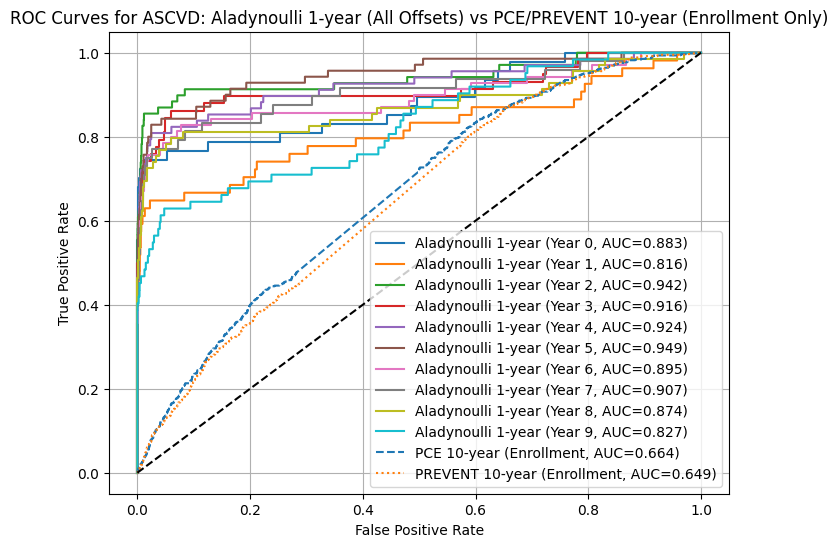

In [101]:
from evaluatetdccode import *
results = evaluate_major_diseases_rolling_1year_roc_curves(
    pi_batches, Y_100k, E_100k, disease_names, pce_df, plot_group='ASCVD'
)

PCE available: True, PREVENT available: True
Patients with valid PCE scores: 10000/10000 (100.0%)
Patients with valid PREVENT scores: 10000/10000 (100.0%)
Offset 0: Included patients: 9556, 1-year Events: 47
  PCE patients: 9556, 1-year Events: 47
  PREVENT patients: 9556, 1-year Events: 47
Offset 1: Included patients: 9509, 1-year Events: 54
  PCE patients: 9509, 1-year Events: 54
  PREVENT patients: 9509, 1-year Events: 54
Offset 2: Included patients: 9455, 1-year Events: 69
  PCE patients: 9455, 1-year Events: 69
  PREVENT patients: 9455, 1-year Events: 69
Offset 3: Included patients: 9386, 1-year Events: 58
  PCE patients: 9386, 1-year Events: 58
  PREVENT patients: 9386, 1-year Events: 58
Offset 4: Included patients: 9328, 1-year Events: 68
  PCE patients: 9328, 1-year Events: 68
  PREVENT patients: 9328, 1-year Events: 68
Offset 5: Included patients: 9260, 1-year Events: 70
  PCE patients: 9260, 1-year Events: 70
  PREVENT patients: 9260, 1-year Events: 70
Offset 6: Included pati

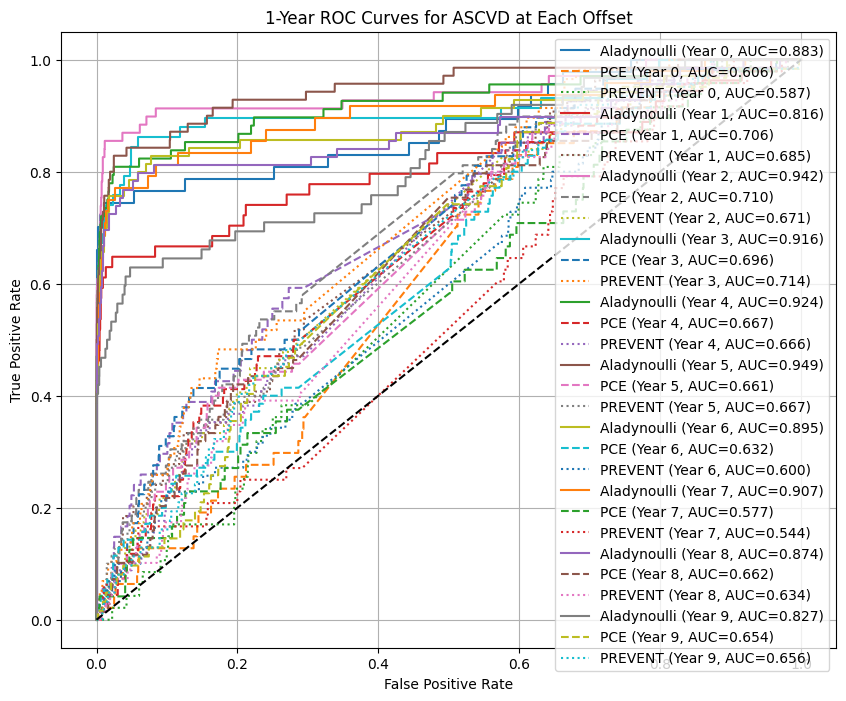

In [124]:
from evaluatetdccode import *
results = evaluate_major_diseases_rolling_1year_roc_curves_highres(
    pi_batches, Y_100k, E_100k, disease_names, pce_df, plot_group='ASCVD'
)

In [102]:
roc_results = evaluate_major_diseases_rolling_1year_roc_curves(
    pi_batches, Y_100k, E_100k, disease_names, pce_df
)

auc_dict = {}
for disease, results in roc_results.items():
    aucs = [auc for (fpr, tpr, thresholds, auc) in results if auc is not None]
    auc_dict[disease] = aucs

PCE available: True, PREVENT available: True
Patients with valid PCE scores: 10000/10000 (100.0%)
Patients with valid PREVENT scores: 10000/10000 (100.0%)
Offset 0: Included patients: 9556, 1-year Events: 47
  PCE patients: 9556, PREVENT patients: 9556, 10-year Events: 615
Offset 1: Included patients: 9509, 1-year Events: 54
Offset 2: Included patients: 9455, 1-year Events: 69
Offset 3: Included patients: 9386, 1-year Events: 58
Offset 4: Included patients: 9328, 1-year Events: 68
Offset 5: Included patients: 9260, 1-year Events: 70
Offset 6: Included patients: 9190, 1-year Events: 70
Offset 7: Included patients: 9120, 1-year Events: 48
Offset 8: Included patients: 9072, 1-year Events: 69
Offset 9: Included patients: 9003, 1-year Events: 62


In [103]:
import pandas as pd

auc_df = pd.DataFrame([
    {'Disease': disease, 'Offset': k, 'AUC': auc}
    for disease, aucs in auc_dict.items()
    for k, auc in enumerate(aucs)
])
summary = auc_df.groupby('Disease')['AUC'].agg(['mean', 'median', 'std', 'min', 'max', 'count'])
print(summary)
# Save the summary statistics
summary.to_csv("rolling_1year_auc_summary_test1000.csv")

                          mean    median       std       min       max  count
Disease                                                                      
ASCVD                 0.893269  0.900794  0.044610  0.816324  0.948871     10
All_Cancers           0.768739  0.772325  0.036414  0.703533  0.840779     10
Anemia                0.722595  0.731505  0.052188  0.596723  0.793816     10
Anxiety               0.724429  0.748641  0.091458  0.546543  0.856011     10
Asthma                0.742978  0.743556  0.035834  0.669655  0.794571     10
Atrial_Fib            0.775068  0.810497  0.077645  0.625449  0.860802     10
Bipolar_Disorder      0.863168  0.849866  0.125323  0.638649  0.992629      9
Bladder_Cancer        0.922683  0.986201  0.097734  0.735863  0.998356     10
Breast_Cancer         0.778725  0.754605  0.111958  0.615031  0.959147     10
CKD                   0.770994  0.787382  0.075445  0.617090  0.871579     10
COPD                  0.744291  0.734129  0.049348  0.695239  0.

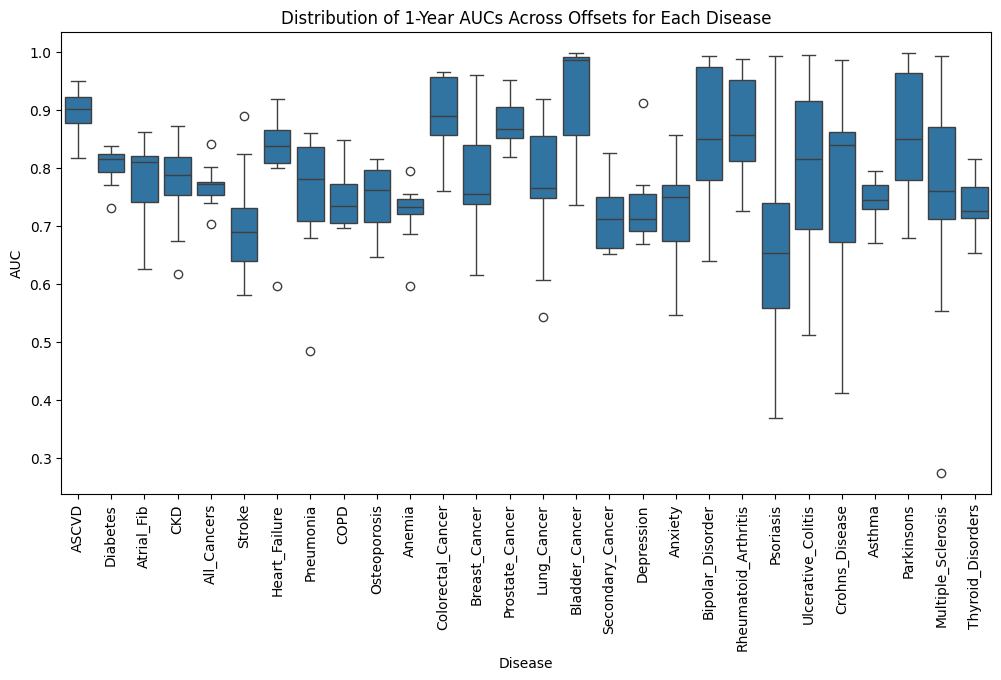

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=auc_df, x='Disease', y='AUC')
plt.xticks(rotation=90)
plt.title('Distribution of 1-Year AUCs Across Offsets for Each Disease')

plt.savefig("1year_auc_distribution_box.pdf", bbox_inches='tight')  # <-- Save to PDF
plt.show()

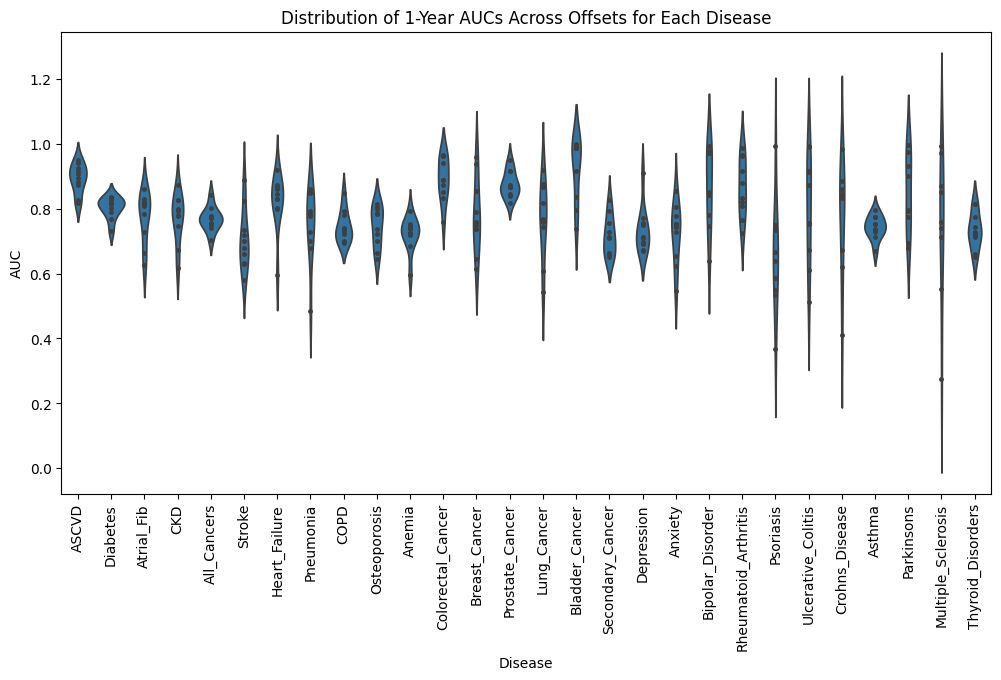

In [107]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=auc_df, x='Disease', y='AUC', inner='point')
plt.xticks(rotation=90)
plt.title('Distribution of 1-Year AUCs Across Offsets for Each Disease')
plt.savefig("1year_auc_distribution.pdf", bbox_inches='tight')  # <-- Save to PDF
plt.show()

In [106]:
from evaluatetdccode import evaluate_major_diseases_wsex_with_bootstrap_dynamic_rolling

results = evaluate_major_diseases_wsex_with_bootstrap_dynamic_rolling(
    pi_batches, Y_100k, E_100k, essentials['disease_names'], pce_df,
    n_bootstraps=100, follow_up_duration_years=10
)

results_df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Disease'})
results_df.to_csv("dynamic_10year_auc_result_rolling_no_leak_offset.csv", index=False)


Evaluating ASCVD (Dynamic 10-Year Risk, Rolling)...
AUC: 0.856 (0.839-0.869) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 831 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk, Rolling)...
AUC: 0.730 (0.702-0.755) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 581 (5.8%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk, Rolling)...
AUC: 0.748 (0.718-0.772) (calculated on 9864 individuals)
Events (10-Year in Eval Cohort): 376 (3.8%) (from 9864 individuals)
Excluded 136 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk, Rolling)...
AUC: 0.745 (0.709-0.774) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 207 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk, Rolling)...
AUC: 0.750 (0.727-0.773) (calculated on 10000 individ

In [93]:
from evaluatetdccode import *
import pandas as pd
#pi_full_year_one=torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_fixedphi_age_offset_0_sex_0_10000_try2.pt")
pi_full_year_one=torch.load("/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_joint_phi_sex_specific.pt")
results = evaluate_major_diseases_wsex_with_bootstrap_pi_input(
    pi_full_year_one, Y_100k, E_100k, disease_names, pce_df,
    n_bootstraps=100, follow_up_duration_years=10, static_10yr_from_1yr=True
)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_88852/2133236494.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_full_year_one=torch.load("/Users/sarahurbu


Evaluating ASCVD (10-Year Outcome, Static 1-Year Pi at Enrollment: True)...
AUC: 0.712 (0.692-0.729) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 831 (8.3%) (from 10000 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (10-Year Outcome, Static 1-Year Pi at Enrollment: True)...
AUC: 0.622 (0.601-0.643) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 581 (5.8%) (from 10000 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (10-Year Outcome, Static 1-Year Pi at Enrollment: True)...
AUC: 0.684 (0.659-0.705) (calculated on 9864 individuals)
Events (10-Year in Eval Cohort): 376 (3.8%) (from 9864 individuals)
Excluded 136 prevalent cases for Atrial_Fib.

Evaluating CKD (10-Year Outcome, Static 1-Year Pi at Enrollment: True)...
AUC: 0.708 (0.670-0.739) (calculated on 10000 individuals)
Events (10-Year in Eval Cohort): 207 (2.1%) (from 10000 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_

In [51]:

disease_names=essentials['disease_names']
# Example: get indices for pre-existing RA
preexisting_indices = []
ra_idx = [i for i, name in enumerate(disease_names) if 'rheumatoid arthritis' in name.lower()]

preexisting_diseases = {
        'Rheumatoid_Arthritis': ['Rheumatoid arthritis'],
        'Breast_Cancer': ['Breast cancer [female]', 'Malignant neoplasm of female breast']
    }

    # Find indices for pre-existing
preexisting_group='Rheumatoid_Arthritis'
preexisting_indices = []
for disease in preexisting_diseases[preexisting_group]:
    preexisting_indices += [i for i, name in enumerate(disease_names) if disease.lower() in name.lower()]
# Find patients with pre-existing at enrollment
preexisting_patients = []
for i, row in enumerate(pce_df.itertuples()):
    age = row.age
    t_enroll = int(age - 30)
    if t_enroll < 0 or t_enroll >= Y_100k.shape[2]:
        continue
    for d_idx in preexisting_indices:
        if torch.any(Y_100k[i, d_idx, :t_enroll] > 0):
            preexisting_patients.append(i)
            break


results_ra = evaluate_major_diseases_wsex_with_bootstrap_dynamic_rolling(
    pi_batches, Y_100k, E_100k, disease_names, pce_df,
    n_bootstraps=100, follow_up_duration_years=10,
    patient_indices=preexisting_patients
)


preexisting_group='Breast_Cancer'
preexisting_indices = []
for disease in preexisting_diseases[preexisting_group]:
    preexisting_indices += [i for i, name in enumerate(disease_names) if disease.lower() in name.lower()]
# Find patients with pre-existing at enrollment
preexisting_patients = []
for i, row in enumerate(pce_df.itertuples()):
    age = row.age
    t_enroll = int(age - 30)
    if t_enroll < 0 or t_enroll >= Y_100k.shape[2]:
        continue
    for d_idx in preexisting_indices:
        if torch.any(Y_100k[i, d_idx, :t_enroll] > 0):
            preexisting_patients.append(i)
            break
results_bc = evaluate_major_diseases_wsex_with_bootstrap_dynamic_rolling(
    pi_batches, Y_100k, E_100k, disease_names, pce_df,
    n_bootstraps=100, follow_up_duration_years=10,
    patient_indices=preexisting_patients
)


Evaluating ASCVD (Dynamic 10-Year Risk, Rolling)...
AUC: 0.686 (0.428-0.922) (calculated on 37 individuals)
Events (10-Year in Eval Cohort): 7 (18.9%) (from 37 individuals)
Excluded 0 prevalent cases for ASCVD.

Evaluating Diabetes (Dynamic 10-Year Risk, Rolling)...
AUC: 0.438 (0.133-0.787) (calculated on 37 individuals)
Events (10-Year in Eval Cohort): 5 (13.5%) (from 37 individuals)
Excluded 0 prevalent cases for Diabetes.

Evaluating Atrial_Fib (Dynamic 10-Year Risk, Rolling)...
AUC: 0.758 (0.606-0.919) (calculated on 36 individuals)
Events (10-Year in Eval Cohort): 4 (11.1%) (from 36 individuals)
Excluded 1 prevalent cases for Atrial_Fib.

Evaluating CKD (Dynamic 10-Year Risk, Rolling)...
AUC: 0.944 (0.873-1.000) (calculated on 37 individuals)
Events (10-Year in Eval Cohort): 1 (2.7%) (from 37 individuals)
Excluded 0 prevalent cases for CKD.

Evaluating All_Cancers (Dynamic 10-Year Risk, Rolling)...
AUC: 0.333 (0.229-0.504) (calculated on 37 individuals)
Events (10-Year in Eval Co

In [45]:
essentials['disease_names']

[np.str_('Bacterial enteritis'),
 np.str_('Viral Enteritis'),
 np.str_('Gram negative septicemia'),
 np.str_('Bacterial infection NOS'),
 np.str_('Staphylococcus infections'),
 np.str_('Streptococcus infection'),
 np.str_('E. coli'),
 np.str_('Viral warts & HPV'),
 np.str_('Viral infection'),
 np.str_('Candidiasis'),
 np.str_('Colon cancer'),
 np.str_('Malignant neoplasm of rectum, rectosigmoid junction, and anus'),
 np.str_('Neoplasm of unspecified nature of digestive system'),
 np.str_('Cancer of bronchus; lung'),
 np.str_('Melanomas of skin'),
 np.str_('Other non-epithelial cancer of skin'),
 np.str_('Breast cancer [female]'),
 np.str_('Malignant neoplasm of female breast'),
 np.str_('Cervical intraepithelial neoplasia [CIN] [Cervical dysplasia]'),
 np.str_('Malignant neoplasm of uterus'),
 np.str_('Malignant neoplasm of ovary'),
 np.str_('Cancer of prostate'),
 np.str_('Malignant neoplasm of kidney, except pelvis'),
 np.str_('Malignant neoplasm of bladder'),
 np.str_('Malignant neo

In [15]:
import pandas as pd

preexisting_group = 'Rheumatoid_Arthritis'  # or 'Breast_Cancer'
all_results = []

for k in range(7):  # or whatever range of offsets you have
    pi_offset = torch.load(f"/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_fixedphi_age_offset_{k}_sex_0_10000_try2.pt")
    result = dynamic_aladynoulli_auc_for_preexisting_dynamic_1year(
        pi_offset, Y_100k, E_100k, essentials['disease_names'], pce_df, 
        preexisting_group=preexisting_group,
        n_bootstraps=20, 
        follow_up_duration_years=1, 
        start_offset=k
    )
    # result is a dict for ASCVD, e.g. {'auc': ..., 'ci_lower': ..., ...}
    result['offset'] = k
    all_results.append(result)

# Convert to DataFrame for easy plotting/summary
df = pd.DataFrame(all_results)
print(df)

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_88852/4197907624.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 28 individuals in cohort
Filtering for Male: Found 9 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.972 (0.913-1.000)       1          2.7        N/A
Diabetes             N/A                       0          0.0        N/A
Atrial_Fib           N/A                       0          0.0        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          N/A                       0          0.0        N/A
Stroke               N/A                       0          0.0        N/A
Heart_Failure        1.000 (1.000-1.000)       1          2.7        N/A
Pneumonia            N/A                       0          0.0        N/A
COPD        

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_88852/4197907624.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 28 individuals in cohort
Filtering for Male: Found 9 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=1):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.972 (0.944-1.000)       1          2.7        N/A
Diabetes             N/A                       0          0.0        N/A
Atrial_Fib           N/A                       0          0.0        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          N/A                       0          0.0        N/A
Stroke               N/A                       0          0.0        N/A
Heart_Failure        N/A                       0          0.0        N/A
Pneumonia            0.167 (0.064-0.278)       1          2.7        N/A
COPD        

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_88852/4197907624.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 28 individuals in cohort
Filtering for Male: Found 9 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=2):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                1.000 (1.000-1.000)       1          2.7        N/A
Diabetes             0.500 (0.000-1.000)       2          5.4        N/A
Atrial_Fib           0.971 (0.907-1.000)       1          2.7        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          N/A                       0          0.0        N/A
Stroke               N/A                       0          0.0        N/A
Heart_Failure        0.972 (0.924-1.000)       1          2.7        N/A
Pneumonia            1.000 (1.000-1.000)       1          2.7        N/A
COPD        

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_88852/4197907624.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 28 individuals in cohort
Filtering for Male: Found 9 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=3):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.843 (0.620-0.931)       2          5.4        N/A
Diabetes             1.000 (1.000-1.000)       1          2.7        N/A
Atrial_Fib           0.971 (0.912-1.000)       1          2.7        N/A
CKD                  1.000 (1.000-1.000)       1          2.7        N/A
All_Cancers          N/A                       0          0.0        N/A
Stroke               N/A                       0          0.0        N/A
Heart_Failure        N/A                       0          0.0        N/A
Pneumonia            N/A                       0          0.0        N/A
COPD        

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_88852/4197907624.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 28 individuals in cohort
Filtering for Male: Found 9 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=4):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                N/A                       0          0.0        N/A
Diabetes             N/A                       0          0.0        N/A
Atrial_Fib           N/A                       0          0.0        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          N/A                       0          0.0        N/A
Stroke               N/A                       0          0.0        N/A
Heart_Failure        N/A                       0          0.0        N/A
Pneumonia            N/A                       0          0.0        N/A
COPD        

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_88852/4197907624.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 28 individuals in cohort
Filtering for Male: Found 9 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=5):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.873 (0.741-1.000)       3          8.1        N/A
Diabetes             0.829 (0.738-0.972)       2          5.4        N/A
Atrial_Fib           N/A                       0          0.0        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          N/A                       0          0.0        N/A
Stroke               N/A                       0          0.0        N/A
Heart_Failure        N/A                       0          0.0        N/A
Pneumonia            0.972 (0.901-1.000)       1          2.7        N/A
COPD        

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_88852/4197907624.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 28 individuals in cohort
Filtering for Male: Found 9 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=6):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.972 (0.926-1.000)       1          2.7        N/A
Diabetes             N/A                       0          0.0        N/A
Atrial_Fib           0.828 (0.664-1.000)       2          5.4        N/A
CKD                  N/A                       0          0.0        N/A
All_Cancers          0.333 (0.203-0.468)       1          2.7        N/A
Stroke               N/A                       0          0.0        N/A
Heart_Failure        0.944 (0.940-0.994)       1          2.7        N/A
Pneumonia            N/A                       0          0.0        N/A
COPD        

In [ ]:
import pandas as pd

for k in range(11):  # 0 through 10 inclusive
    pi_offset = torch.load(f"/Users/sarahurbut/Library/CloudStorage/Dropbox/pi_enroll_age_offset_{k}_sex_0_10000.pt")
    results = evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year_different_start_end(
        pi_offset, Y_100k, E_100k, model.disease_names, pce_df, 
        n_bootstraps=20, 
        follow_up_duration_years=1, 
        start_offset=k
    )
    # Convert results dict to DataFrame
    df = pd.DataFrame(results).T.reset_index().rename(columns={'index': 'Disease'})
    df['offset'] = k
    df.to_csv(f"results_offset_{k}.csv", index=False)


/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/3520701371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=0):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.856 (0.814-0.904)       78         0.8        N/A
Diabetes             0.732 (0.680-0.804)       33         0.3        N/A
Atrial_Fib           0.794 (0.665-0.887)       22         0.2        N/A
CKD                  0.874 (0.546-0.997)       4          0.0        N/A
All_Cancers          0.765 (0.708-0.832)       26         0.3        N/A
Stroke               0.731 (0.708-0.843)       5          0.1        N/A
Heart_Failure        0.846 (0.746-0.958)       15         0.1        N/A
Pneumonia            0.484 (0.357-0.558)       15         0.1        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/3520701371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=1):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.846 (0.800-0.892)       87         0.9        N/A
Diabetes             0.732 (0.671-0.797)       53         0.5        N/A
Atrial_Fib           0.777 (0.648-0.893)       22         0.2        N/A
CKD                  0.612 (0.381-0.712)       5          0.1        N/A
All_Cancers          0.741 (0.682-0.805)       44         0.4        N/A
Stroke               0.798 (0.498-0.969)       5          0.1        N/A
Heart_Failure        0.664 (0.284-0.996)       5          0.1        N/A
Pneumonia            0.661 (0.527-0.869)       12         0.1        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/3520701371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=2):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.878 (0.857-0.907)       115        1.1        N/A
Diabetes             0.744 (0.706-0.797)       56         0.6        N/A
Atrial_Fib           0.745 (0.686-0.801)       35         0.4        N/A
CKD                  0.816 (0.559-1.000)       5          0.1        N/A
All_Cancers          0.802 (0.761-0.847)       45         0.4        N/A
Stroke               0.693 (0.528-0.862)       9          0.1        N/A
Heart_Failure        0.789 (0.715-0.886)       18         0.2        N/A
Pneumonia            0.800 (0.715-0.862)       33         0.3        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/3520701371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=3):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.864 (0.821-0.894)       104        1.0        N/A
Diabetes             0.739 (0.674-0.829)       54         0.5        N/A
Atrial_Fib           0.763 (0.677-0.852)       32         0.3        N/A
CKD                  0.874 (0.794-0.999)       8          0.1        N/A
All_Cancers          0.708 (0.659-0.756)       52         0.5        N/A
Stroke               0.631 (0.526-0.755)       13         0.1        N/A
Heart_Failure        0.784 (0.608-0.904)       13         0.1        N/A
Pneumonia            0.691 (0.429-0.808)       23         0.2        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/3520701371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=4):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.871 (0.844-0.901)       114        1.1        N/A
Diabetes             0.696 (0.646-0.756)       56         0.6        N/A
Atrial_Fib           0.749 (0.694-0.848)       45         0.4        N/A
CKD                  0.672 (0.449-0.826)       14         0.1        N/A
All_Cancers          0.798 (0.739-0.846)       61         0.6        N/A
Stroke               0.823 (0.680-0.919)       10         0.1        N/A
Heart_Failure        0.869 (0.757-0.961)       10         0.1        N/A
Pneumonia            0.724 (0.664-0.818)       32         0.3        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/3520701371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=5):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.890 (0.858-0.917)       128        1.3        N/A
Diabetes             0.659 (0.556-0.714)       53         0.5        N/A
Atrial_Fib           0.743 (0.668-0.820)       58         0.6        N/A
CKD                  0.773 (0.651-0.847)       23         0.2        N/A
All_Cancers          0.767 (0.716-0.877)       45         0.4        N/A
Stroke               0.645 (0.493-0.776)       14         0.1        N/A
Heart_Failure        0.799 (0.751-0.878)       28         0.3        N/A
Pneumonia            0.773 (0.631-0.873)       29         0.3        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/3520701371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=6):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.870 (0.847-0.910)       134        1.3        N/A
Diabetes             0.659 (0.622-0.703)       79         0.8        N/A
Atrial_Fib           0.758 (0.670-0.816)       59         0.6        N/A
CKD                  0.736 (0.677-0.802)       26         0.3        N/A
All_Cancers          0.721 (0.668-0.803)       45         0.4        N/A
Stroke               0.606 (0.532-0.749)       23         0.2        N/A
Heart_Failure        0.849 (0.780-0.920)       38         0.4        N/A
Pneumonia            0.755 (0.672-0.838)       39         0.4        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/3520701371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=7):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.877 (0.840-0.918)       105        1.1        N/A
Diabetes             0.657 (0.629-0.720)       71         0.7        N/A
Atrial_Fib           0.628 (0.559-0.649)       48         0.5        N/A
CKD                  0.755 (0.665-0.832)       29         0.3        N/A
All_Cancers          0.722 (0.663-0.759)       68         0.7        N/A
Stroke               0.722 (0.498-0.848)       15         0.1        N/A
Heart_Failure        0.813 (0.757-0.905)       29         0.3        N/A
Pneumonia            0.842 (0.804-0.891)       54         0.5        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/3520701371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=8):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.863 (0.836-0.890)       128        1.3        N/A
Diabetes             0.637 (0.564-0.703)       67         0.7        N/A
Atrial_Fib           0.699 (0.612-0.775)       36         0.4        N/A
CKD                  0.773 (0.736-0.824)       46         0.5        N/A
All_Cancers          0.733 (0.706-0.785)       70         0.7        N/A
Stroke               0.673 (0.535-0.753)       24         0.2        N/A
Heart_Failure        0.861 (0.799-0.947)       30         0.3        N/A
Pneumonia            0.847 (0.804-0.872)       59         0.6        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/3520701371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=9):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.833 (0.797-0.865)       110        1.1        N/A
Diabetes             0.669 (0.644-0.733)       74         0.7        N/A
Atrial_Fib           0.624 (0.536-0.721)       19         0.2        N/A
CKD                  0.738 (0.687-0.790)       62         0.6        N/A
All_Cancers          0.631 (0.581-0.703)       74         0.7        N/A
Stroke               0.693 (0.552-0.798)       18         0.2        N/A
Heart_Failure        0.858 (0.760-0.928)       37         0.4        N/A
Pneumonia            0.849 (0.794-0.886)       59         0.6        N/A
COPD   

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_72344/3520701371.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi_offset = torch.load(f"/Users/sarahurbut/Li

Filtering for Female: Found 5409 individuals in cohort
Filtering for Male: Found 4591 individuals in cohort

Summary of Results (1-Year Risk, Sex-Adjusted, Offset=10):
--------------------------------------------------------------------------------
Disease Group        AUC                       Events     Rate (%)   C-index   
--------------------------------------------------------------------------------
ASCVD                0.850 (0.800-0.899)       109        1.1        N/A
Diabetes             0.656 (0.604-0.690)       82         0.8        N/A
Atrial_Fib           0.515 (0.272-0.739)       6          0.1        N/A
CKD                  0.786 (0.744-0.828)       57         0.6        N/A
All_Cancers          0.709 (0.669-0.755)       88         0.9        N/A
Stroke               0.794 (0.734-0.856)       34         0.3        N/A
Heart_Failure        0.885 (0.836-0.930)       40         0.4        N/A
Pneumonia            0.740 (0.684-0.797)       70         0.7        N/A
COPD  